# Split-Seed Recall Check (Decision Tree)

After using the Flank Wear Failure (FWF) values for the Degradation Tool, other types of failure are used to evaluate the quality of the drilling process. For this reason the Build-up Edge Failure (BEF) and Compression Chips Failure (CCF) values are used from the dataset to determine binarily results: GOOD or BAD quality. 

Using the same logic as before, we can create decision tree models that create a logic process to understand what values are needed for a good prediction.

This file is responsible for fine-tuning the parameters of the train-test split such that we obtain the best recall and precision combination. 


Goal: evaluate how **recall/precision** changes when only the **train–test split seed** varies.

- BEF/CCF test using all features
- CCF test using selected features


Software Lab 2025 Group 25

File made by:  Nien-Ying Lin (03803153)
go57vov@tum.de

Documentation made by: Nien-Ying Lin (03803153) and Eduardo Silva (03805057)

# 1) Imports

Importing all the necessary libraries needed to evaluate the BEF and CCF criteria for quality.

In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# 2) Dataset Path and Feature Alignment


In [21]:
BASE_DIR = Path.cwd()
# get dataset file path
DATA_PATH = BASE_DIR.parent.parent / "Dataset/XAI_Drilling_Dataset.csv"


CANONICAL_MAP = {
    "Cutting_speed": ["Cutting_speed", "Cutting speed vc [m/min]"],
    "Spindle_speed": ["Spindle_speed", "Spindle speed n [1/min]"],
    "Feed_f": ["Feed_f", "Feed f [mm/rev]"],
    "Feed_rate": ["Feed_rate", "Feed rate vf [mm/min]"],
    "Power_Pc": ["Power_Pc", "Power Pc [kW]"],
    "Cooling": ["Cooling", "Cooling [%]"],
    "Process_Time": ["Process_Time", "Process Time [sec]"],
    "Material": ["Material"],
    "Drill_Bit_Type": ["Drill_Bit_Type", "Drill Bit Type"],
    "BEF": ["BEF"], "CCF": ["CCF"], "FWF": ["FWF"], "WDF": ["WDF"]
}

## 2.1) BEF/CCF Recall Test (All Features Used)

### Settings
Key experiment parameters. We keep the model fixed and sweep the train–test split seed
to evaluate recall/precision stability.

We adjust:
- `TARGET`
- `SPLIT_SEED_RANGE`
- `MAX_DEPTH`

In [22]:
# Target label: choose "BEF" or "CCF"
TARGET = "CCF"

# Sweep the 'split seed' to measure metric variability caused by data partitioning
SPLIT_SEED_RANGE = range(0, 300)

# Depth of the tree
MAX_DEPTH = 4 if TARGET == "BEF" else 6

CRITERION = "gini"
MIN_SAMPLES_SPLIT = 2
MIN_SAMPLES_LEAF = 1

TEST_SIZE = 0.20
TOP_K = 10

## 2.2) Helper Functions

In [23]:
def _safe_get(df, variants):
    for c in variants:
        if c in df.columns:
            return df[c]
    raise KeyError(f"Missing any of columns: {variants}")

def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)



## 2.3) Preprocessing

It is necessary to encode the non-numerical values from the dataset. For this reason, we created the following numerical analogy for the values of the material and the drill bit. 

Category Reference

| Feature         | Category | Code |
|----------------|----------|---------------|
| Material       | K        | 0             |
| Material       | N        | 1             |
| Material       | P        | 2             |
| Drill_Bit_Type | H        | 0             |
| Drill_Bit_Type | N        | 1             |
| Drill_Bit_Type | W        | 2             |


In [24]:
def load_and_prepare(path, target_col):
    raw = pd.read_csv(path)
    df = pd.DataFrame()

    for canon, variants in CANONICAL_MAP.items():
        try:
            df[canon] = _safe_get(raw, variants)
        except KeyError:
            pass  
    
    num_cols = [c for c in ["Cutting_speed","Spindle_speed","Feed_f","Feed_rate","Power_Pc","Cooling","Process_Time"] if c in df.columns]
    cat_cols = [c for c in ["Material","Drill_Bit_Type"] if c in df.columns]

    # Ensure numeric dtypes
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Target y
    y = df[target_col].astype(int).values

    # Preprocessor: passthrough numeric, OHE for categoricals
    pre = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", make_ohe(), cat_cols),
        ],
        remainder="drop"
    )

    X = df[num_cols + cat_cols]
    return X, y, pre, num_cols, cat_cols




## 2.4) Split-Seed Sweep
For each split seed: train the same decision tree and record recall, precision, F1-score caused by data partitioning.

In [25]:
def run_split_sweep(X_raw, y, preproc, max_depth, split_seed_range):
    """Sweep over train/test split random_state and report metrics."""
    results = []
    for split_seed in split_seed_range:
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_raw, y, test_size=TEST_SIZE, stratify=y, random_state=split_seed
        )
        pipe = Pipeline(steps=[
            ("pre", preproc),
            ("dt", DecisionTreeClassifier(
                criterion=CRITERION,
                max_depth=max_depth,
                min_samples_split=MIN_SAMPLES_SPLIT,
                min_samples_leaf=MIN_SAMPLES_LEAF,
                random_state=0  
            ))
        ])
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)

        acc  = accuracy_score(y_te, y_pred)
        rec  = recall_score(y_te, y_pred, zero_division=0)
        prec = precision_score(y_te, y_pred, zero_division=0)
        f1   = f1_score(y_te, y_pred, zero_division=0)
        cm   = confusion_matrix(y_te, y_pred)

        results.append({
            "split_seed": split_seed,
            "accuracy": acc, "recall": rec, "precision": prec, "f1": f1,
            "tn": int(cm[0,0]), "fp": int(cm[0,1]), "fn": int(cm[1,0]), "tp": int(cm[1,1])
        })

    return pd.DataFrame(results)




# 3) Visualization & Run

Features used -> numeric: ['Cutting_speed', 'Spindle_speed', 'Feed_f', 'Feed_rate', 'Power_Pc', 'Cooling', 'Process_Time'] | categorical: ['Material', 'Drill_Bit_Type']
Positive rate (CCF=1): 344 / 20000 (1.72%)
max_depth = 6 | sweep = split seeds

=== Top by Recall (then F1, Precision) ===
 split_seed   recall       f1  precision  accuracy  tp  fn  fp   tn
        299 0.971014 0.978102   0.985294   0.99925  67   2   1 3930
         53 0.956522 0.977778   1.000000   0.99925  66   3   0 3931
        119 0.956522 0.977778   1.000000   0.99925  66   3   0 3931
        137 0.956522 0.977778   1.000000   0.99925  66   3   0 3931
        145 0.956522 0.977778   1.000000   0.99925  66   3   0 3931
        165 0.956522 0.977778   1.000000   0.99925  66   3   0 3931
         22 0.956522 0.970588   0.985075   0.99900  66   3   1 3930
         93 0.956522 0.970588   0.985075   0.99900  66   3   1 3930
         48 0.956522 0.963504   0.970588   0.99875  66   3   2 3929
        192 0.956522 0.96350

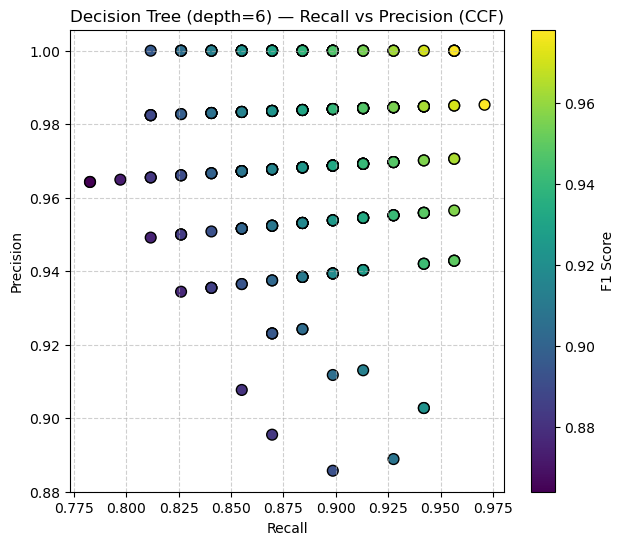

In [26]:
def plot_scatter(df_res, target, max_depth):
    plt.figure(figsize=(7,6))
    sc = plt.scatter(
        df_res["recall"], df_res["precision"],
        c=df_res["f1"], cmap="viridis", s=60, edgecolor="k"
    )
    plt.colorbar(sc, label="F1 Score")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Decision Tree (depth={max_depth}) — Recall vs Precision ({target})")
    plt.grid(True, linestyle="--", alpha=0.6)

def main():
    X_raw, y, preproc, used_num, used_cat = load_and_prepare(DATA_PATH, TARGET)
    print(f"Features used -> numeric: {used_num} | categorical: {used_cat}")
    print(f"Positive rate ({TARGET}=1): {int(y.sum())} / {len(y)} ({y.mean()*100:.2f}%)")
    print(f"max_depth = {MAX_DEPTH} | sweep = split seeds")

    df_res = run_split_sweep(X_raw, y, preproc, MAX_DEPTH, SPLIT_SEED_RANGE)
    df_res = df_res.sort_values(by=["recall","f1","precision"], ascending=[False, False, False]).reset_index(drop=True)

    print("\n=== Top by Recall (then F1, Precision) ===")
    print(df_res.head(TOP_K)[
        ["split_seed","recall","f1","precision","accuracy","tp","fn","fp","tn"]
    ].to_string(index=False))

    plot_scatter(df_res, TARGET, MAX_DEPTH)

if __name__ == "__main__":
    main()

# 4) CCF Recall Test (Selected Features)

To simplify complex rules, we train the model using selected features. We conduct a seed sweep to confirm that high recall is achievable before proceeding to rule extraction.

Features used -> numeric: ['Feed_rate', 'Cooling'] | categorical: ['Material', 'Drill_Bit_Type']

=== Top by Recall (then F1, Precision) ===
 split_seed   recall  precision       f1
         51 1.000000   0.971831 0.985714
        456 1.000000   0.971831 0.985714
        861 1.000000   0.971831 0.985714
         93 0.985507   0.985507 0.985507
        268 0.985507   0.985507 0.985507
        355 0.985507   0.985507 0.985507
        518 0.985507   0.985507 0.985507
        696 0.985507   0.985507 0.985507
        798 0.985507   0.985507 0.985507
        299 0.985507   0.971429 0.978417


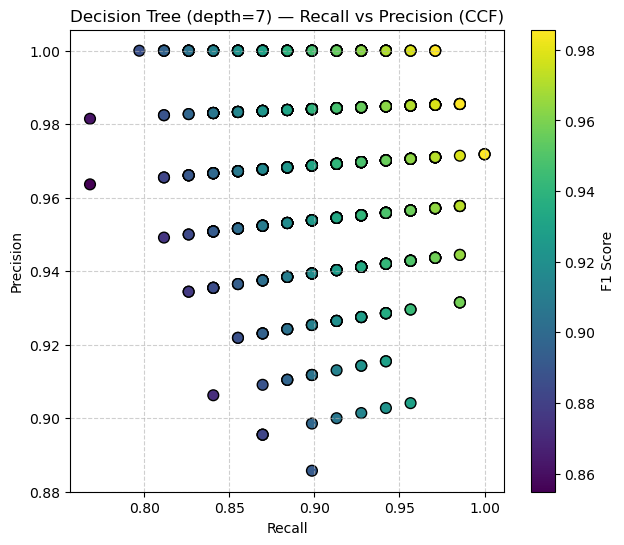

In [20]:
# Select Features (Adjust Here)
SELECT_NUM_VARS = ["Cooling", "Feed_rate"] 
SELECT_CAT_VARS = ["Material", "Drill_Bit_Type"]

# 2. Settings
NEW_SPLIT_SEED_RANGE = range(0, 1000)
NEW_MAX_DEPTH = 7
NEW_TARGET = "CCF"

# 3. new load_and_prepare function for selected features
def load_and_prepare_v2(path, target_col, sel_num, sel_cat):
    raw = pd.read_csv(path)
    df = pd.DataFrame()
    for canon, variants in CANONICAL_MAP.items():
        try: df[canon] = _safe_get(raw, variants)
        except KeyError: pass
    
    available_num = [c for c in ["Cutting_speed","Spindle_speed","Feed_f","Feed_rate","Power_Pc","Cooling","Process_Time"] if c in df.columns]
    available_cat = [c for c in ["Material","Drill_Bit_Type"] if c in df.columns]
    
    num_cols = available_num if sel_num is None else [c for c in available_num if c in sel_num]
    cat_cols = available_cat if sel_cat is None else [c for c in available_cat if c in sel_cat]

    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    
    y = df[target_col].astype(int).values
    pre = ColumnTransformer(transformers=[
        ("num", "passthrough", num_cols),
        ("cat", make_ohe(), cat_cols),
    ], remainder="drop")

    X = df[num_cols + cat_cols]
    return X, y, pre, num_cols, cat_cols

# 4. run
X_v2, y_v2, pre_v2, used_num, used_cat = load_and_prepare_v2(DATA_PATH, NEW_TARGET, SELECT_NUM_VARS, SELECT_CAT_VARS)
print(f"Features used -> numeric: {used_num} | categorical: {used_cat}")

# sweep
df_res_v2 = run_split_sweep(X_v2, y_v2, pre_v2, NEW_MAX_DEPTH, NEW_SPLIT_SEED_RANGE)

# sort and result
df_res_v2 = df_res_v2.sort_values(by=["recall","f1","precision"], ascending=[False, False, False]).reset_index(drop=True)

print("\n=== Top by Recall (then F1, Precision) ===")
print(df_res_v2.head(TOP_K)[["split_seed","recall","precision","f1"]].to_string(index=False))

# plot
plot_scatter(df_res_v2, NEW_TARGET, NEW_MAX_DEPTH)